In [1]:
from clipppy import load_config
from matplotlib import pyplot as plt
import torch, pyro, numpy as np 
import collections, os
import corner
from ruamel.yaml import YAML


import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *
from channels import split_channels

In [2]:
VERSION_NAME = 'testing'

STORE_DIR = 'training_data_lens_source'
STORE_DIR_VERSION = os.path.join(STORE_DIR, VERSION_NAME)
os.makedirs(STORE_DIR, exist_ok = True)
os.makedirs(STORE_DIR_VERSION, exist_ok = True)

PARAMS = YAML().load(open('params.yaml'))['lens_source']

In [3]:
losses_name = os.path.join(STORE_DIR_VERSION, f'losses_{VERSION_NAME}.pt')
guide_name  = os.path.join(STORE_DIR_VERSION, f'guide_{VERSION_NAME}.pt')

In [4]:
config = load_config('config_gen_mock_lens_source.yaml')
model = config.umodel
guide = config.guide

obs = config.conditioning['image']

/home/eliasd/.pyenv/versions/3.9.7/envs/lens-3.9.7/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# cmc = model.cmc
n_channels  = model.n_channels
sigma_stat = model.stochastic_specs['sigma_stat']

# print(f'cmc = {cmc}, sigma_stat = {sigma_stat}, n_channels = {n_channels}')

/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:102: RuntimeWarning: Getting items from StochasticSpecs by name is frowned upon and only supports explicitly named specs at the first level that at most come from mappings (no dynamic generation).
  warn(f'Getting items from {type(self).__name__} by name is frowned upon'


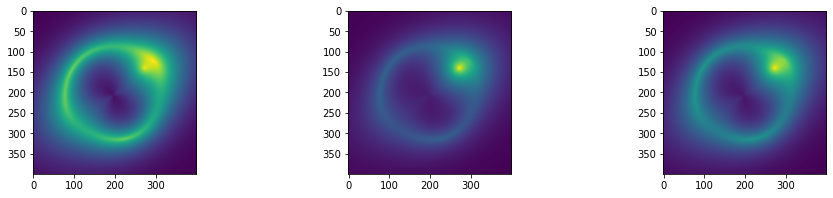

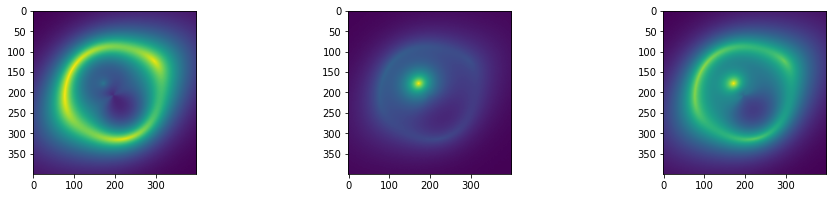

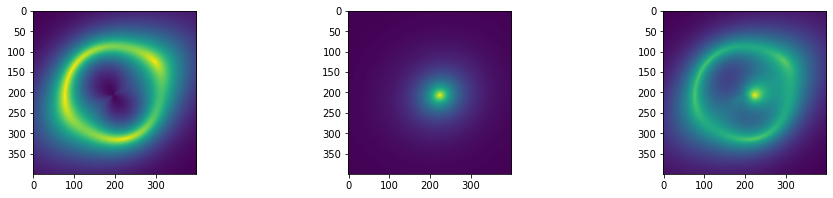

In [6]:
if n_channels >= 2:
    plot_imshow(split_channels(model()), size_y = 3)
    plot_imshow(split_channels(model()), size_y = 3)
    plot_imshow(split_channels(obs), size_y = 3)
if n_channels == 1:
    plot_imshow([model(), model(), obs, obs], size_y = 3)

In [7]:
from clipppy.stochastic import Sampler

def set_init(values):
    for lens in values:
        for spec in lens.stochastic_specs.values():
            if isinstance(spec, Sampler):
                name = lens.stochastic_name + '/' + spec.name
                if name in PARAMS['init']: 
                    spec.init = spec.infer['init'] = PARAMS['init'][name]
                    print(f'{name:<15}set to {spec.init}')

                    
# model.lenslight['sersic2'].stochastic_specs['phi'] = PARAMS['truth']['sersic2/phi']
                    
set_init(model.lenslight.values())
set_init(model.alphas.values())
set_init(model.sources.values())
# set_init(model.cmc.values())



lenslight2/x   set to 0.0
lenslight2/y   set to 0.0


/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:129: RuntimeWarning: Iterating values from StochasticSpecs is frowned upon and returns the raw specs!
  warn(f'Iterating values from {type(self).__name__} is frowned upon'


In [8]:
# for i in range(nbatch):
#     print(f'starting batch {i}')
    
#     values = [model.lenslight.values(), model.alphas.values(), model.sources.values()]
    
#     for m in values:
#         set_init(values)
        
#     pyro.clear_param_store()
#     guide.setup()
#     losses = []

In [9]:
guide.setup()

guide

Guide(
  (MultivariateNormal): MultivariateNormalSamplingGroup(3 sites, torch.Size([3]))
)

In [10]:
losses = []

if not os.path.isfile(guide_name) or VERSION_NAME == 'testing':
    print('Training!')

    guide.train() 
    
#     while len(losses) < 2000:
    
        # losses += config.fit(lr=1e-2, n_steps=1000)
    losses = config.fit(n_steps = 100)

    
    torch.save(losses, losses_name)
    torch.save(guide, guide_name)

else: 
    print('Already trained!')

print('Loading!')
guide = config.guide = torch.load(guide_name)
losses = np.array(torch.load(losses_name))

Training!


  0%|          | 0/100 [00:00<?, ?it/s]

Loading!


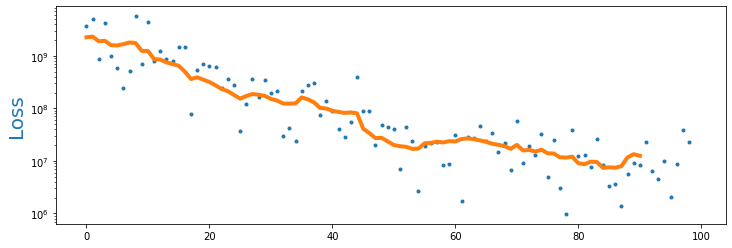

In [11]:
plot_log(losses, N = True)

parameter       truth    mean              diff
cmc             0.1     +0.03599 ± 0.01756 +0.06401
lenslight2/x    0.3     +0.31680 ± 0.04832 -0.01680
lenslight2/y    0.1     +0.08558 ± 0.03632 +0.01442


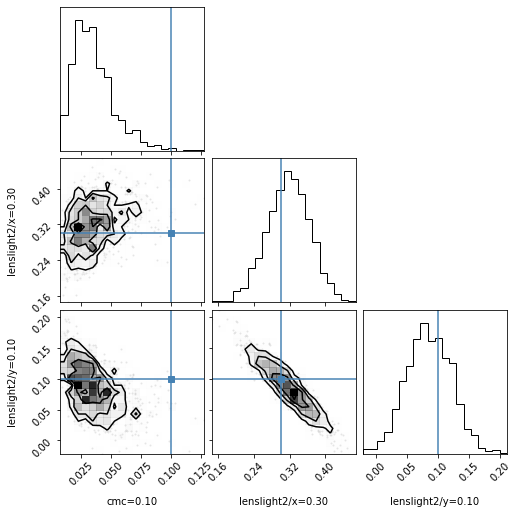

In [12]:
def plot_guide(nsamples = 1000):
    
    params = PARAMS['truth']
    
    with pyro.plate('plate', nsamples):
        ppd = config.guide()
    
    ppd = {key: val for key, val in ppd.items()}
    names = [k for k in ppd.keys()]
    truths = [params.get(k, None) for k in ppd.keys()]
    labels = [f'{name}={truth:.2f}' for name, truth in zip(names, truths)]
    
    print(f'{"parameter":<15} {"truth":<8} {"mean":17} {"diff"}')
    for (k, v), truth in zip(ppd.items(), truths): 
        sigma = f'({truth}{v.mean()-truth:+f}: {abs((truth - v.mean()) / v.std()):.1f}-sigma)'
        print(f'{k:<15} {truth:<7} {v.mean():+.5f} ± {v.std():.5f} {truth - v.mean():+.5f}')
    


    return corner.corner( np.stack([v.detach().numpy() for v in ppd.values()], -1), 
                         truths = truths, labels = labels);



    
plot_guide(nsamples = 1000);

In [13]:
def plot_fit_resids(nsamples = 1000):
    pred = torch.stack([config.ppd()['model_trace'].nodes['mu']['value'] for i in range(nsamples)], 0).mean(0)
                
    if n_channels >= 2:
        obss  = split_channels(obs)
        preds = split_channels(pred)
        diffs = (obss - preds)
        plots = torch.cat((obss, preds, diffs))
        titles = np.array([[f'{j} channel {i+1}' for i in range(n_channels)] + [f'{j} total'] for j in ['truth', 'pred', 'diff']]).flatten()
        return plot_imshow(plots = plots, nrows = 3, colorbar = True, titles = titles)
    
    else:
        plots = [obs, pred, obs - pred]
        titles = ['truth', 'mu pred', 'diff truth and mu pred', 'truth', 'mode pred', 'diff truth and mode pred', 'truth', 'mean pred', 'diff truth and mean pred', 'mode pred', 'mean pred', 'diff mode pred and mean pred']
    
        return plot_imshow(plots = plots, colorbar = True, titles = titles)

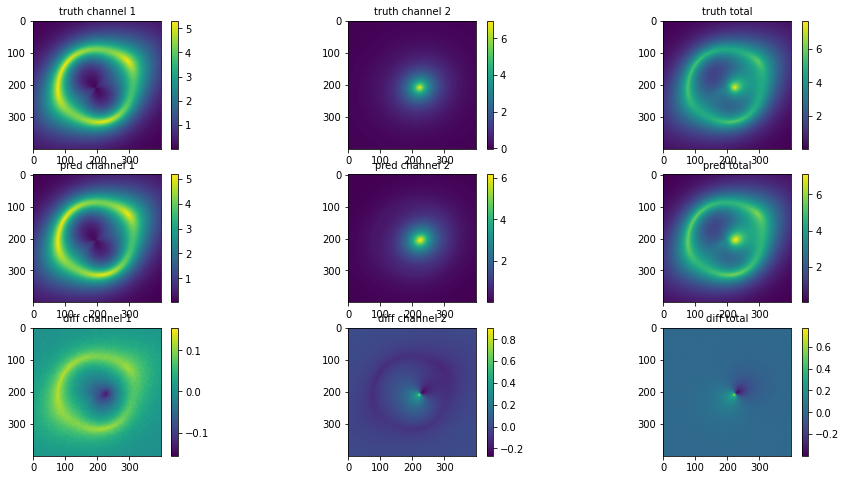

In [14]:
plot_fit_resids(nsamples = 100)